
# <center> DDPM and DDIM

<div align=center>

[KAIST CS492(C): Diffusion and Flow Models (Fall 2025)](https://mhsung.github.io/kaist-cs492c-fall-2025/)

Programming Assignment 1: DDPM and DDIM

Instructor: [Minhyuk Sung](https://mhsung.github.io) (mhsung [at] kaist.ac.kr)

TA: [Yunhong Min](https://myh4832.github.io/) (dbsghd363 [at] kaist.ac.kr)

Credit: [Juil Koo](https://63days.github.io) (63days [at] kaist.ac.kr) & [Nguyen Minh Hieu](https://hieuristics.xyz/) (hieu1052k3 [at] gmail.com)

<img src="https://drive.google.com/uc?id=1O85toQTt3DjIeQZ8aHXPydc5AsganCDJ"></img>
</div>

## Abstract
In this programming assignment, you will implement two representative diffusion-based generative models: the **Denoising Diffusion Probabilistic Model (DDPM)** and the **Denoising Diffusion Implicit Model (DDIM)**. Using a simple 2D toy dataset, you will train a noise prediction network and investigate both the forward and reverse processes of these models. The goal of this assignment is to gain hands-on experience in building diffusion models and to understand how DDPM and DDIM can exhibit different sampling behaviors, even when sharing the same noise prediction network.

Before you start the assignment, we encourage you to review the following material for better understanding of the background of diffusion models:

1. [[Paper](https://arxiv.org/abs/2006.11239)] Denoising Diffusion Probabilistic Models
2. [[Paper](https://arxiv.org/abs/2010.02502)] Denoising Diffusion Implicit Models
3. [[Blog](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/)] Lilian Wang's "What are Diffusion Models?"

<center>

**Detailed submission guidelines and grading criteria are provided at the end of this Jupyter notebook.**

</center>

## Quick Summary of DDPM and DDIM

<center>
You can skip this summary and go directly to the implementation part below if you are already familiar with these models.
</center>

### Forward Process
Denoising Diffusion Probabilistic Model (DDPM) is one of latent variable generative models consisting of a Markov chain. In the Markov chain, let us define a _forward process_ that gradually adds noise to the data sampled from a data distribution $\mathbf{x}_0 \sim q(\mathbf{x}_0)$ so that $\mathbf{x}_0$ becomes pure white Gaussian noise at $t=T$. Each transition of the forward process is as follows:

$$ q(\mathbf{x}_t | \mathbf{x}_{t-1} := N(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I})$$

where a variance schedule $\beta_1, \dots, \beta_T$ controlls the step sizes.

Thanks to a nice property of Gaussians, we can directly sample $\mathbf{x}_t$ at an arbitary timestep $t$ from real data $\mathbf{x}_0$ in a closed form:

$$ q(\mathbf{x}_t | \mathbf{x}_0) = N (\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathbf{I}), $$

where $\alpha_t := 1 - \beta_t$ and $\bar{\alpha}_t := \Pi_{s=1}^T \alpha_s$.

### Reverse Process
If we can reverse the forward process, i.e. sample $\mathbf{x}_{t-1} \sim q(\mathbf{x}_{t-1} | \mathbf{x}_t)$ iteratively until $t=0$, we will be able to generate $\mathbf{x}_0$ which is close to the unknown data distribution $\mathbf{q}(\mathbf{x}_0)$ from white Gaussian noise $\mathbf{x}_T \sim N(0, \mathbf{I})$. You can think of this _reverse process_ as denoising process that gradually denoises noise so that it looks like a true sample from $q(\mathbf{x}_0)$ at the end.
The reverse process is also a Markov chain with learned Gaussian transitions:

$$p_\theta(\mathbf{x}_{0:T}) := p(\mathbf{x}_T) \prod_{t=1}^T p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t), $$

where $p(\mathbf{x}_T) = N(0, \mathbf{I})$ and $p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t) := {N}(\mathbf{x}_{t-1}; \mathbf{\boldsymbol{\mu}}_\theta (\mathbf{x}_t, t)\boldsymbol{\Sigma}_\theta (\mathbf{x}_t, t)).$

### Training
To learn this reverse process, we set an objective function that minimizes KL divergence between $p_\theta(\mathbf{x}_{t-1} | \mathbf{x}_t)$ and $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t, \mathbf{x}_0), \sigma_t^2 \mathbf{I})$ which is also a Gaussian distribution when conditioned on $\mathbf{x}_0$:

$$L = \mathbb{E}_q \left[ \sum_{t > 1} D\_{\text{KL}}( q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) \Vert p_\theta ( \mathbf{x}_{t-1} | \mathbf{x}_t)) \right].$$

As a parameterization of DDPM, the authors set $\boldsymbol{\Sigma}_\theta(\mathbf{x}_t, t) = \sigma_t^2 \mathbf{I}$ to untrained time dependent constants. As a result, we can rewrite the objective function:

$${L} = \mathbb{E}_q \left[ \frac{1}{2\sigma_t^2} \Vert \tilde{\boldsymbol{\mu}}_t(\mathbf{x}_t, \mathbf{x}_0) - \boldsymbol{\mu}_{\theta}(\mathbf{x}_t, t) \Vert^2 \right] + C $$

The authors empirically found that predicting $\epsilon$ noise injected to data by a noise prediction network $\epsilon_\theta$ is better than learning the mean function $\boldsymbol{\mu}\_\theta$.

In short, the simplified objective function of DDPM is defined as follows:

$$ {L}_{\text{simple}} := \mathbb{E}_{t,\mathbf{x}_0,\boldsymbol{\epsilon}} [ \Vert \boldsymbol{\epsilon} - \boldsymbol{\epsilon}_\theta( \mathbf{x}_t(\mathbf{x}_0, t), t) \Vert^2  ],$$

where $\mathbf{x}_t (\mathbf{x}_0, t) = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$ and $\boldsymbol{\epsilon} \sim {N}(0, \mathbf{I})$.

Refer to [the original DDPM paper](https://arxiv.org/abs/2006.11239) for more details.

### Sampling

Once we train the noise prediction network $\boldsymbol{\epsilon}_\theta$, we can run sampling by gradually denoising white Gaussian noise. The algorithm of the DDPM  sampling is shown below:
<center>
<img src="https://drive.google.com/uc?id=1JW0-f81xlRrVNT84ATwHelVofT0i1Aex"></src>
</center>

### Speed-Up with DDIM Sampling

By now, you might be familiar with the concept of DDPM, particularly how it generates samples by gradually removing noise from the data.

One downside of DDPM is the need to go through around a thousand of denoising steps to fully denoise the data, which is time-consuming. Surprisingly, the sampling process of DDPM can be accelerated with a simple mathematical tweak, **without the need to retrain the model from scratch**.

Recall that the algorithm for DDPM sampling is nothing but a sequence of noise predictions and denoising steps. To speed up sampling, we keep the pre-trained DDPM and only switch each step within the loop (line 4 in Algorithm 2) to the following:

<center>
<img src="https://drive.google.com/uc?id=12MJ1DYn6iGA_ZWxLAV_nOEJro6DJc_DY"></src>
</center>

Note that the symbol $\alpha_t$ in the DDIM paper corresponds to $\bar{\alpha}_t$ in the DDPM paper.

## Setup

Before getting started, go to `Runtime` → `Change runtime type` on the top menu bar, and choose **T4 GPU** under Hardware Accelerator.

You should then see `True` and the GPU status with the commands below:

In [ ]:
import torch
print(torch.cuda.is_available())
!nvidia-smi

True
Wed Oct  1 09:23:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             27W /   70W |     164MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

## Import Dependencies

In [ ]:
import io
import math
from ipywidgets import interact, IntSlider, Output
from IPython.display import display, clear_output
from PIL import Image
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
from scipy.spatial.distance import cdist
from sklearn import datasets
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
SEED = 1234         # WARNING: DO NOT CHANGE THE SEED

## Dataset and Utils

In [ ]:
def seed_everything(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

def normalize(ds, scaling_factor=2.0):
    return (ds - ds.mean()) / ds.std() * scaling_factor


def chamfer_distance(S1, S2) -> float:
    r"""
    Computes the Chamfer distance between two point clouds defined as:
    d_CD(S1, S2) = \sigma_{x \in S1} min_{y in S2} ||x - y||^2 + \sigma_{y \in S2} min_{x in S1} ||x - y||^2
    """
    dist = cdist(S1, S2)
    dist1 = dist.min(axis=1) ** 2
    dist2 = dist.min(axis=0) ** 2
    return dist1.sum() + dist2.sum()


def sample_checkerboard(n):
    # https://github.com/ghliu/SB-FBSDE/blob/main/data.py
    n_points = 3 * n
    n_classes = 2
    freq = 5
    x = np.random.uniform(
        -(freq // 2) * np.pi, (freq // 2) * np.pi, size=(n_points, n_classes)
    )
    mask = np.logical_or(
        np.logical_and(np.sin(x[:, 0]) > 0.0, np.sin(x[:, 1]) > 0.0),
        np.logical_and(np.sin(x[:, 0]) < 0.0, np.sin(x[:, 1]) < 0.0),
    )
    y = np.eye(n_classes)[1 * mask]
    x0 = x[:, 0] * y[:, 0]
    x1 = x[:, 1] * y[:, 0]
    sample = np.concatenate([x0[..., None], x1[..., None]], axis=-1)
    sqr = np.sum(np.square(sample), axis=-1)
    idxs = np.where(sqr == 0)
    sample = np.delete(sample, idxs, axis=0)

    return sample


def load_twodim(num_samples: int, dataset: str, dimension: int = 2):

    if dataset == "gaussian_centered":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample

    if dataset == "gaussian_shift":
        sample = np.random.normal(size=(num_samples, dimension))
        sample = sample + 1.5

    if dataset == "circle":
        X, y = datasets.make_circles(
            n_samples=num_samples, noise=0.0, random_state=None, factor=0.5
        )
        sample = X * 4

    if dataset == "scurve":
        X, y = datasets.make_s_curve(
            n_samples=num_samples, noise=0.0, random_state=None
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "moon":
        X, y = datasets.make_moons(n_samples=num_samples, noise=0.0, random_state=None)
        sample = normalize(X)

    if dataset == "swiss_roll":
        X, y = datasets.make_swiss_roll(
            n_samples=num_samples, noise=0.0, random_state=None, hole=True
        )
        sample = normalize(X[:, [0, 2]])

    if dataset == "checkerboard":
        sample = normalize(sample_checkerboard(num_samples))

    return torch.tensor(sample).float()


class TwoDimDataClass(Dataset):
    def __init__(self, dataset_type: str, N: int, batch_size: int, dimension=2):

        self.X = load_twodim(N, dataset_type, dimension=dimension)
        self.name = dataset_type
        self.batch_size = batch_size
        self.dimension = 2

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]

    def get_dataloader(self, shuffle=True):
        return DataLoader(
            self,
            batch_size=self.batch_size,
            shuffle=shuffle,
            pin_memory=True,
        )


def get_data_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()


## Visualize target and prior distributions

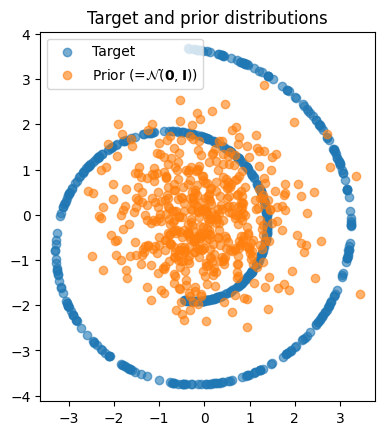

In [ ]:
# Set seed
seed_everything(SEED)

target_ds = TwoDimDataClass(dataset_type='swiss_roll',
                            N=1000000,
                            batch_size=256)

prior_ds = TwoDimDataClass(dataset_type='gaussian_centered',
                           N=1000000,
                           batch_size=256)

num_vis_particles = 500
sample_f = target_ds[0:num_vis_particles]
sample_b = prior_ds[0:num_vis_particles]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sample_f[:, 0], sample_f[:, 1], alpha=0.6)
ax.scatter(sample_b[:, 0], sample_b[:, 1], alpha=0.6)
ax.grid(False)
ax.set_aspect('equal', adjustable='box')
strtitle = "Target and prior distributions"
ax.set_title(strtitle)
ax.legend(['Target', r'Prior (=$\mathcal{N}(\mathbf{0}, \mathbf{I})$)'])

## Task 1: DDPM with Swiss-Roll

In this task, we will look into each component one by one in a toy experiment and implement them sequentally. After finishing the implementation, you will be able to train DDPM and evaluate the performance.

❗️❗️❗️ **You are only allowed to edit the code enclosed with TODO comments. Do NOT modify any code outside these regions.** ❗️❗️❗️

## Task 1-1: Implement a Noise Prediction Neural Network

Implement a noise prediction network based on the provided skeleton code. The network should consist of `TimeLinear` layers with feature dimensions following the sequence `[dim_in, dim_hids[0], ..., dim_hids[-1], dim_out]`. Each `TimeLinear` layer except for the last one must be followed by a ReLU activation.

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period)
            * torch.arange(start=0, end=half, dtype=torch.float32)
            / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat(
                [embedding, torch.zeros_like(embedding[:, :1])], dim=-1
            )
        return embedding

    def forward(self, t: torch.Tensor):
        if t.ndim == 0:
            t = t.unsqueeze(-1)
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class TimeLinear(nn.Module):
    def __init__(self, dim_in: int, dim_out: int, num_timesteps: int):
        super().__init__()
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.num_timesteps = num_timesteps

        self.time_embedding = TimeEmbedding(dim_out)
        self.fc = nn.Linear(dim_in, dim_out)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.fc(x)
        alpha = self.time_embedding(t).view(-1, self.dim_out)

        return alpha * x


class SimpleNet(nn.Module):
    def __init__(
        self, dim_in: int, dim_out: int, dim_hids: List[int], num_timesteps: int
    ):
        super().__init__()
        """
        (TODO) Build a noise estimating network.

        Args:
            dim_in: dimension of input
            dim_out: dimension of output
            dim_hids: dimensions of hidden features
            num_timesteps: number of timesteps
        """

        ######## TODO ########
        # DO NOT change the code outside this part.
        dims = [dim_in] + dim_hids + [dim_out]
        self.tlins = nn.ModuleList()

        for i in range(len(dims) - 1):
          self.tlins.append(TimeLinear(dims[i], dims[i+1], num_timesteps))

        ######################

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        (TODO) Implement the forward pass. This should output
        the noise prediction of the noisy input x at timestep t.

        Args:
            x: the noisy data after t period diffusion
            t: the time that the forward diffusion has been running
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        for i in range(len(self.tlins)):
          x = self.tlins[i](x, t)
          if i < len(self.tlins) - 1:  # no activation after the last layer
            x = F.relu(x)

        ######################
        return x


## Task 1-2: Complete a DDPM scheduler.

Compute `alphas` and `alphas_cumprod`, which correspond to the sequences of $\alpha_t:=1-\beta_t$ and $\bar{\alpha}_t:=\Pi_{s=1}^t \alpha_s$, respectively (as defined in the DDPM paper).

In [ ]:
class BaseScheduler(nn.Module):
    """
    Variance scheduler of DDPM.
    """

    def __init__(
        self,
        num_train_timesteps: int,
        beta_1: float = 1e-4,
        beta_T: float = 0.02,
        mode: str = "linear",
    ):
        super().__init__()
        self.num_train_timesteps = num_train_timesteps
        self.timesteps = torch.from_numpy(
            np.arange(0, self.num_train_timesteps)[::-1].copy().astype(np.int64)
        )

        if mode == "linear":
            betas = torch.linspace(beta_1, beta_T, steps=num_train_timesteps)
        elif mode == "quad":
            betas = (
                torch.linspace(beta_1**0.5, beta_T**0.5, num_train_timesteps) ** 2
            )
        else:
            raise NotImplementedError(f"{mode} is not implemented.")

        ######## TODO ########
        # DO NOT change the code outside this part.
        # Compute alphas and alphas_cumprod.
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)

        ######################

        self.register_buffer("betas", betas)
        self.register_buffer("alphas", alphas)
        self.register_buffer("alphas_cumprod", alphas_cumprod)

## Task 1-3: Complete the core functions of DDPM.

Implement forward and reverse processes of DDPM inside the class below.

- `q_sample()` is a forward pass that maps $\mathbf{x}_0$ to $\mathbf{x}_t$.  

- `p_sample()` is a reverse transition from $\mathbf{x}_t$ to $\mathbf{x}_{t-1}$, and

- `p_sample_loop()` is the full iterative reverse process, corresponding to the DDPM sampling algorithm.

Finally, implement the training objective:
- `comput_loss()` should be the simplified noise matching loss in the DDPM paper.


In [ ]:
def extract(input, t: torch.Tensor, x: torch.Tensor):
    if t.ndim == 0:
        t = t.unsqueeze(0)
    shape = x.shape
    t = t.long().to(input.device)
    out = torch.gather(input, 0, t)
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

class DDPM(nn.Module):
    """
    A high-level wrapper of DDPM.
    """

    def __init__(self, network: nn.Module, var_scheduler: BaseScheduler):
        super().__init__()
        self.network = network
        self.var_scheduler = var_scheduler

    @property
    def device(self):
        return next(self.network.parameters()).device

    def q_sample(self, x0, t, noise=None):
        """
        sample x_t from q(x_t | x_0) of DDPM.

        Input:
            x0 (`torch.Tensor`): clean data to be mapped to timestep t in the forward process of DDPM.
            t (`torch.Tensor`): timestep
            noise (`torch.Tensor`, optional): random Gaussian noise. if None, randomly sample Gaussian noise in the function.
        Output:
            xt (`torch.Tensor`): noisy samples
        """
        if noise is None:
            noise = torch.randn_like(x0)

        ######## TODO ########
        # DO NOT change the code outside this part.
        # Compute xt.
        alphas_prod_t = extract(self.var_scheduler.alphas_cumprod, t, x0)
        xt = torch.sqrt(alphas_prod_t) * x0 + torch.sqrt(1 - alphas_prod_t) * noise

        #######################

        return xt

    @torch.no_grad()
    def p_sample(self, xt, t):
        """
        One step denoising function of DDPM: x_t -> x_{t-1}.

        Input:
            xt (`torch.Tensor`): samples at arbitrary timestep t.
            t (`torch.Tensor`): current timestep in a reverse process.
        Ouptut:
            x_t_prev (`torch.Tensor`): one step denoised sample. (= x_{t-1})

        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        # compute x_t_prev.
        if isinstance(t, int):
            t = torch.tensor([t]).to(self.device)
        eps_factor = (1 - extract(self.var_scheduler.alphas, t, xt)) / (
            1 - extract(self.var_scheduler.alphas_cumprod, t, xt)
        ).sqrt()
        eps_theta = self.network(xt, t)
        mean = (1 / torch.sqrt(extract(self.var_scheduler.alphas, t, xt)))*(xt - eps_factor * eps_theta)

        if t[0] > 0:
            noise = torch.randn_like(xt)
            x_t_prev = mean + torch.sqrt(extract(self.var_scheduler.betas, t, xt)) * noise
        else:
            x_t_prev = mean

        #######################
        return x_t_prev

    @torch.no_grad()
    def p_sample_loop(self, shape):
        """
        The loop of the reverse process of DDPM.

        Input:
            shape (`Tuple`): The shape of output. e.g., (num particles, 2)
        Output:
            x0_pred (`torch.Tensor`): The final denoised output through the DDPM reverse process.
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        # sample x0 based on Algorithm 2 of DDPM paper.
        x0_pred = torch.randn(shape).to(self.device)

        # 2. reverse process loop
        for t in reversed(range(self.var_scheduler.num_train_timesteps)):
          t_tensor = torch.tensor([t]).to(self.device)

            # one reverse step (your p_sample already does Algorithm 2 line 4)
          x0_pred = self.p_sample(x0_pred, t_tensor)


        ######################
        return x0_pred

    def compute_loss(self, x0):
        """
        The simplified noise matching loss corresponding Equation 14 in DDPM paper.

        Input:
            x0 (`torch.Tensor`): clean data
        Output:
            loss: the computed loss to be backpropagated.
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        # compute noise matching loss.
        batch_size = x0.shape[0]
        t = (
            torch.randint(0, self.var_scheduler.num_train_timesteps, size=(batch_size,))
            .to(x0.device)
            .long()
        )
        eps = torch.randn_like(x0)
        alpha_bar_t = extract(self.var_scheduler.alphas_cumprod, t, x0)

        xt = torch.sqrt(alpha_bar_t)*x0 + torch.sqrt(1.00 - alpha_bar_t)*eps
        eps_theta = self.network(xt, t)

        loss = F.mse_loss(eps_theta, eps)

        ######################
        return loss

## Build a DDPM

In [ ]:
# hyperparameters #
# Don't change it
device = torch.device("cuda")
config = {
    "num_diffusion_steps": 1000,
    "dim_hids": [128, 128, 128],
    "lr": 1e-3,
    "batch_size": 128,
    "num_train_iters": 5000,
    "device": device,
}
###################

def build_ddpm(config):
    network = SimpleNet(dim_in=2,
                        dim_out=2,
                        dim_hids=config["dim_hids"],
                        num_timesteps=config["num_diffusion_steps"]
                       )
    var_scheduler = BaseScheduler(config["num_diffusion_steps"])

    ddpm = DDPM(network, var_scheduler).to(config["device"])
    return ddpm

ddpm = build_ddpm(config)

## Visualize $q(\mathbf{x}_t)$

Once you finish the implementation so far, you should be able to see that the swiss-roll distribution on the leftmost gradually transforms into a Gaussian distribution as $t$ increases.

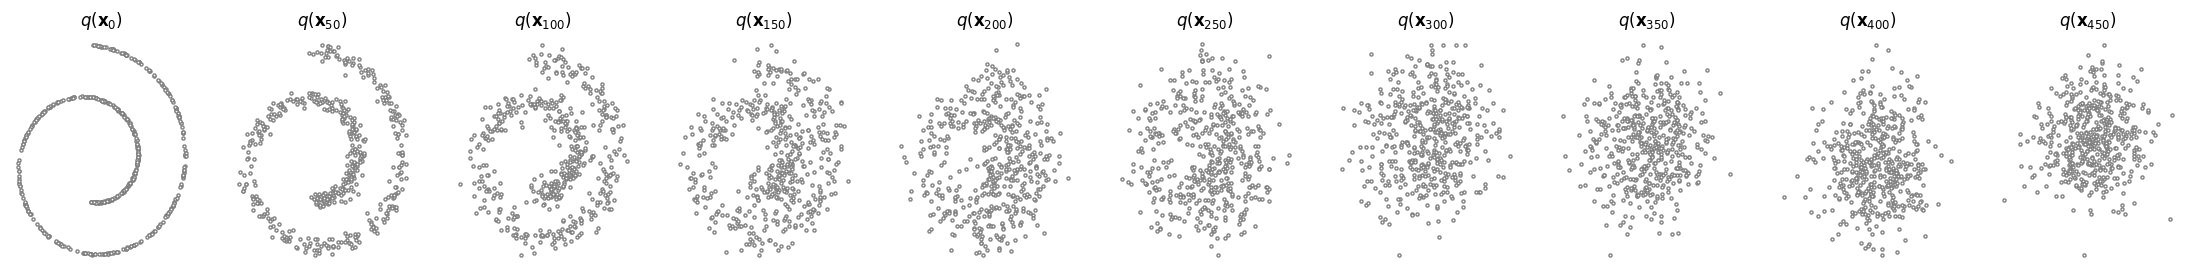

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i, t in enumerate(range(0, 500, 50)):
    x_t = ddpm.q_sample(target_ds[:num_vis_particles].to(device), (torch.ones(num_vis_particles) * t).to(device))
    x_t = x_t.cpu()
    axs[i].scatter(x_t[:,0], x_t[:,1], color='white',edgecolor='gray', s=5)
    axs[i].set_axis_off()
    axs[i].set_title(r'$q(\mathbf{x}_{'+str(t)+'})$')

## Training

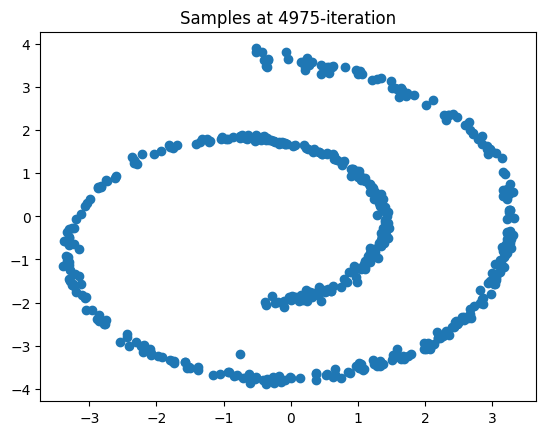

loss: 0.3679: 100%|██████████| 5000/5000 [01:37<00:00, 51.29it/s]


interactive(children=(IntSlider(value=1, description='index', max=25), Output()), _dom_classes=('widget-intera…

Output()

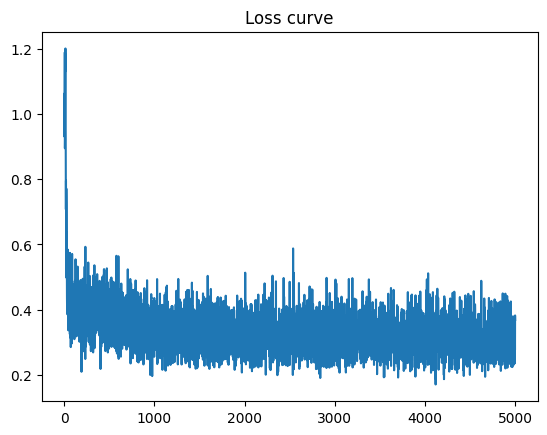

In [ ]:
def figure2image(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

# Set seed
seed_everything(SEED)

# Initialize the model.
ddpm = build_ddpm(config)

pbar = tqdm(range(config["num_train_iters"]))
optimizer = torch.optim.Adam(ddpm.parameters(), lr=config["lr"])
train_dl = torch.utils.data.DataLoader(target_ds, batch_size=config["batch_size"])
train_iter = get_data_iterator(train_dl)

losses = []
images = []
try:
    for step in pbar:
        optimizer.zero_grad()

        batch_x = next(train_iter)
        batch_x = batch_x.to(device)
        loss = ddpm.compute_loss(batch_x)

        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss: {loss.item():.4f}")

        losses.append(loss.item())

        if step % 199 == 0:
            with torch.no_grad():
                x0 = ddpm.p_sample_loop(shape=(num_vis_particles, 2)).cpu()

                fig, ax = plt.subplots(1,1)
                ax.scatter(x0[:,0], x0[:,1])
                ax.set_title(f"Samples at {step}-iteration")
                clear_output(wait=True)
                plt.show()
                img = figure2image(fig)
                images.append(img)

except KeyboardInterrupt:
    pass
finally:
    if len(images) > 0:
        slider = IntSlider(min=0, max=len(images)-1, step=1, value=1)
        output = Output()
        def display_image(index):
            with output:
                output.clear_output(wait=True)
                display(images[index])
        interact(display_image, index=slider)
        display(output)
        plt.plot(losses)
        plt.title("Loss curve")

## Task 1 DDPM Evaluation

DDPM Chamfer Distance: 15.2078


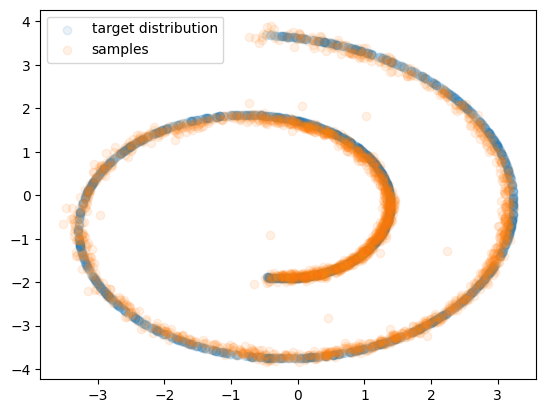

In [ ]:
# Set seed
seed_everything(SEED)

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = ddpm.p_sample_loop(shape=(num_eval_particles, 2))

pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()
with torch.no_grad():
    cd = chamfer_distance(
        pc_gen,
        pc_ref,
    )
    print(f"DDPM Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()

## Task 2: Implement a DDIM

Now, we will complete the implementation of DDIM, which shares the same forward process with DDPM but use a different reverse process. After finishing the implementation, you will evaluate the DDIM sampling performance while using the same noise prediction network from the previous DDPM sampling.


Complete `ddim_p_sample()` and `ddim_p_sample_loop()` functions in the DDIM class.

❗️❗️❗️ **You are only allowed to edit the code enclosed with TODO comments. Do NOT modify any code outside these regions.** ❗️❗️❗️

In [ ]:
class DDIM(DDPM):
    """
    A high-level wrapper of DDIM.
    """

    @torch.no_grad()
    def ddim_p_sample(self, xt, t, t_prev, eta=0.0):
        """
        One step denoising function of DDIM: $x_t{\tau_i}$ -> $x_{\tau{i-1}}$.

        Input:
            xt (`torch.Tensor`): noisy data at timestep $\tau_i$.
            t (`torch.Tensor`): current timestep (=\tau_i)
            t_prev (`torch.Tensor`): next timestep in a reverse process (=\tau_{i-1})
            eta (float): correspond to η in DDIM which controls the stochasticity of a reverse process.
        Output:
           x_t_prev (`torch.Tensor`): one step denoised sample. (= $x_{\tau_{i-1}}$)
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        # Compute x_t_prev based on ddim reverse process, following Equation 12 of the DDIM paper.
        alpha_prod_t = extract(self.var_scheduler.alphas_cumprod, t, xt)
        if t_prev >= 0:
            alpha_prod_t_prev = extract(self.var_scheduler.alphas_cumprod, t_prev, xt)
        else:
            alpha_prod_t_prev = torch.ones_like(alpha_prod_t)

        eps_theta = self.network(xt, t)
        eps = torch.randn_like(xt)
        sigma = eta * torch.sqrt((1 - alpha_prod_t_prev)/(1 - alpha_prod_t)) * torch.sqrt(1- (alpha_prod_t/alpha_prod_t_prev))

        pred_x0 = (xt - torch.sqrt(1-alpha_prod_t)*eps_theta)/torch.sqrt(alpha_prod_t)
        direction_to_x0 = torch.sqrt(1- alpha_prod_t_prev- sigma**2) * eps_theta

        x_t_prev = torch.sqrt(alpha_prod_t_prev) * pred_x0 + direction_to_x0 + sigma * eps

        ######################
        return x_t_prev

    @torch.no_grad()
    def ddim_p_sample_loop(self, shape, num_inference_timesteps=50, eta=0.0):
        r"""
        The loop of the reverse process of DDIM.

        Input:
            shape (`Tuple`): The shape of output. e.g., (num particles, 2)
            num_inference_timesteps (`int`): the number of timesteps in the reverse process.
            eta (`float`): correspond to η in DDIM which controls the stochasticity of a reverse process.
        Output:
            x0_pred (`torch.Tensor`): The final denoised output through the DDPM reverse process.
        """
        ######## TODO ########
        # DO NOT change the code outside this part.
        step_ratio = self.var_scheduler.num_train_timesteps // num_inference_timesteps
        timesteps = (
            (np.arange(0, num_inference_timesteps) * step_ratio)
            .round()[::-1]
            .copy()
            .astype(np.int64)
        )
        timesteps = torch.from_numpy(timesteps)
        prev_timesteps = timesteps - step_ratio

        xt = torch.randn(shape).to(self.device)
        for t, t_prev in zip(timesteps, prev_timesteps):
          t = torch.tensor([t]).to(self.device)
          t_prev = torch.tensor([t_prev]).to(self.device)
          xt = self.ddim_p_sample(xt, t, t_prev, eta=eta)

        x0_pred = xt

        ######################

        return x0_pred


## Task 2 DDIM Evaluation

We will load the same pre-trained noise prediction network used in the previous DDPM sampling, and then sample data following the DDIM reverse process.

DDIM Chamfer Distance: 32.2105


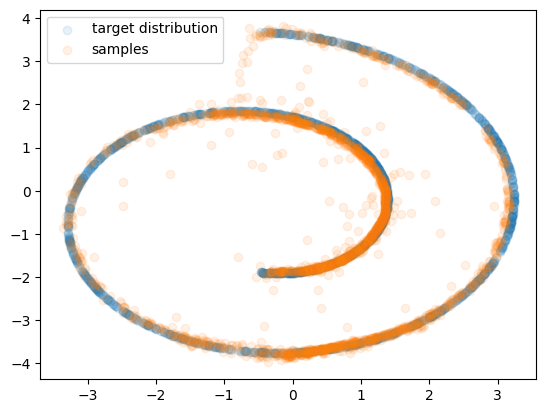

In [ ]:
# Set seed
seed_everything(SEED)

ddim = DDIM(ddpm.network, ddpm.var_scheduler).to(config["device"])

num_eval_particles = 2048
pc_ref = target_ds[:num_eval_particles]
pc_gen = ddim.ddim_p_sample_loop(shape=(num_eval_particles, 2))

pc_gen = pc_gen.reshape(num_eval_particles, 2).cpu().numpy()
pc_ref = pc_ref.reshape(num_eval_particles, 2).cpu().numpy()
with torch.no_grad():
    cd = chamfer_distance(
        pc_gen,
        pc_ref,
    )
    print(f"DDIM Chamfer Distance: {cd.item():.4f}")

# Visualize samples with the target distribution.
fig, ax = plt.subplots(1,1)
ax.scatter(pc_ref[:,0], pc_ref[:,1], alpha=0.1, label="target distribution")
ax.scatter(pc_gen[:,0], pc_gen[:,1], alpha=0.1, label="samples")
ax.legend()
plt.show()

## What to Submit

<details>
<summary><b>Submission Item List</b></summary>
</br>

- [ ] Jupyter notebook file

**Task 1 (DDPM)**
- [ ] Loss curve screenshot
<img src="https://drive.google.com/uc?id=1UemwPik_2MbDgVURvdxC02MHkrFkn0Na"></img>

- [ ] Screenshot of Chamfer Distance result
- [ ] Visualization of DDPM sampling
<img src="https://drive.google.com/uc?id=1CR-YzIOYxMvYG7cmBJuWIY_00mFPejvP"></img>



**Task 2 (DDIM)**
- [ ] Screenshot of Chamfer Distance result
- [ ] Visualization of DDIM sampling

<img src="https://drive.google.com/uc?id=1Atg5pri-0JihV0b7mk7b9r77T-2sxw95"></img>
</details>


Submit a single ZIP file named `{NAME}_{STUDENT_ID}.zip` containing the two followings:

1. Jupyter notebook file containing your code implementation.
2. A single PDF document named `{NAME}_{STUDENT_ID}.pdf` that includes:
    - Your name and student ID
    - All results listed in the submission item list above (screenshots, metrics, visualizations, etc.)


## Grading

**You will receive a zero score if:**
- **you do not submit,**
- **your code is not reproducible, or**
- **you modify any code outside of the section enclosed with `TODO` or use different hyperparameters that are supposed to be fixed as given.**

**Plagiarism in any form will also result in a zero score and will be reported to the university.**

**Your score will incur a 10% deduction for each missing item.**

Otherwise, you will receive up to 20 points from this assignment that count toward your final grade.

- Task 1
  - 10 points: Achieve CD lower than **20** from DDPM sampling.
  - 5 points: Achieve CD between **20** and **40** from DDPM sampling.
  - 0 point: otherwise.
- Task 2
  - 10 points: Achieve CD lower than **40** from DDIM sampling.
  - 5 points: Achieve CD between **40** and **80** from DDIM sampling.
  - 0 point: otherwise.


## Further Readings

If you are interested in this topic, we encourage you to check out the further materials below.

- [Diffusion Models Beat GANs on Image Synthesis](https://arxiv.org/abs/2105.05233)
- [Score-Based Generative Modeling through Stochastic Differential Equations](https://arxiv.org/abs/2011.13456)
- [Generative Modeling by Estimating Gradients of the Data Distribution](https://yang-song.net/blog/2021/score/)